## Bitcoin data crawling

In [154]:
from binance_historical_data import BinanceDataDumper 
import datetime 
import os 
import pandas as pd 
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
import mplfinance as mpf
import seaborn as sns
import numpy as np
from scipy.stats import norm 


In [155]:
data_dumper = BinanceDataDumper(
    path_dir_where_to_dump="Data", # save data in "Data" folder
    asset_class="spot", # spot market 
    data_type="klines", # "klines" means candlestick data
    data_frequency='1m' # 1 minute frequency
)

# Download historical data for BTCUSDT from Jan 1, 2023 to now 
start_date = datetime.datetime(2023, 1, 1)
data_dumper.dump_data(
    tickers=["BTCUSDT"],
    date_start=datetime.date(2023, 1, 1),
    date_end=None, # None means up to current date
    is_to_update_existing=False # do not update existing data files
)

print("Data download completed.")

---> Found overall tickers: 3439
---> Filter to asked tickers: 1
------> Tickers left: 1
Download full data for 1 tickers: 
---> Data will be saved here: d:\Tài liệu học tập\Khai phá và phân tích dữ liệu\Group Assignment\Notebooks\Data\spot
---> Data Frequency: 1m
---> Start Date: 20230101
---> End Date: 20251206


d:\Python\Lib\site-packages\binance_historical_data\data_dumper.py:131: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  date_end = datetime.datetime.utcnow().date() - relativedelta(days=1)
d:\Python\Lib\site-packages\binance_historical_data\data_dumper.py:132: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  if date_end > datetime.datetime.utcnow().date()  - relativedelta(days=1):


Tickers:   0%|          | 0/1 [00:00<?, ?it/s]

d:\Python\Lib\site-packages\binance_historical_data\data_dumper.py:300: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  date_end = datetime.datetime.utcnow().date()


monthly files to download:   0%|          | 0/35 [00:00<?, ?files/s]

d:\Python\Lib\site-packages\binance_historical_data\data_dumper.py:300: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  date_end = datetime.datetime.utcnow().date()


daily files to download:   0%|          | 0/6 [00:00<?, ?files/s]

Tried to dump data for 1 tickers:
---> For BTCUSDT new data saved for: 35 months 6 days
Data download completed.


### Integrate Bitcoin data

In [156]:
# 1. Setup paths
base_dir = "Data"
target_path_1 = os.path.join(base_dir, "spot", "monthly", "klines", "BTCUSDT", "1m")
target_path_2 = os.path.join(base_dir, "spot", "daily", "klines", "BTCUSDT", "1m")

column_names = [
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_buy_base_asset_volume", "taker_buy_quote_asset_volume", "ignored"
]

def load_data(path):
    if not os.path.exists(path):
        return []
    files = [os.path.join(path, f) for f in os.listdir(path) if f.endswith('.csv')]
    # Read without headers
    return [pd.read_csv(f, header=None, names=column_names) for f in files]

# 2. Load and Combine
print("Loading data...")
df_list = load_data(target_path_1) + load_data(target_path_2)

if not df_list:
    raise ValueError("No data found!")

df_combined = pd.concat(df_list, ignore_index=True)

# 3. Normalize Mixed Timestamps
# ---------------------------------------------------------
# Logic: A timestamp in 2024/2025 is ~1.7 trillion in ms (13 digits).
# In microseconds, it is ~1.7 quadrillion (16 digits).
# We set a threshold: if number > 10 trillion (10^13), it must be microseconds.
# ---------------------------------------------------------

# Ensure column is numeric first
df_combined['open_time'] = pd.to_numeric(df_combined['open_time'])

# Divide by 1000 ONLY where the number is huge (microseconds)
df_combined['open_time'] = np.where(
    df_combined['open_time'] > 10_000_000_000_000,  # Threshold
    df_combined['open_time'] / 1000,                # Action if True (convert us to ms)
    df_combined['open_time']                        # Action if False (keep as ms)
)

# 4. Convert to Datetime (Now everything is milliseconds)
print("Converting timestamps...")
df_combined['open_time'] = pd.to_datetime(df_combined['open_time'], unit='ms')

# 5. Clean, Sort, and Save
df_combined = df_combined.sort_values(by='open_time').drop_duplicates(subset=['open_time']).reset_index(drop=True)
df_combined = df_combined.drop(columns=['ignored', 'close_time'])  # Drop 'ignored' column

# Split to train/test 
# Train: 2023-01-01 to 2024-12-31
# Test: 2025-01-01 onwards
train_end_date = datetime.datetime(2024, 12, 31, 23, 59, 59)
df_train = df_combined[df_combined['open_time'] <= train_end_date]
df_test = df_combined[df_combined['open_time'] > train_end_date]

output_file = "Data/bitcoin_data_train.csv"
df_train.to_csv(output_file, index=False)
df_test.to_csv("Data/bitcoin_data_test.csv", index=False)

print(f"Success! Saved to {output_file}")
print(f"Total Rows: {len(df_combined)}")
print(f"Start Date: {df_combined['open_time'].min()}")
print(f"End Date:   {df_combined['open_time'].max()}")

Loading data...
Converting timestamps...
Success! Saved to Data/bitcoin_data_train.csv
Total Rows: 1542160
Start Date: 2023-01-01 00:00:00
End Date:   2025-12-06 23:59:00


In [157]:
df_train.head()

,open_time,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume
0,2023-01-01 00:00:00,16541.77,16544.76,16538.45,16543.67,83.08143,1.374269e+06,2687,40.18369,6.647060e+05
1,2023-01-01 00:01:00,16543.04,16544.41,16538.48,16539.31,80.45300,1.330773e+06,2890,33.28428,5.505633e+05
2,2023-01-01 00:02:00,16539.31,16541.17,16534.52,16536.43,62.90197,1.040248e+06,1930,20.73999,3.430094e+05
3,2023-01-01 00:03:00,16536.43,16537.28,16531.00,16533.65,115.71894,1.913268e+06,2956,49.40758,8.169194e+05
4,2023-01-01 00:04:00,16534.12,16536.08,16527.51,16535.38,144.45369,2.388081e+06,3795,76.52421,1.265080e+06


## Data Understanding

In [158]:
# load data
df = pd.read_csv("Data/bitcoin_data_train.csv")
df['open_time'] = pd.to_datetime(df['open_time'])
df.set_index('open_time', inplace=True)

# Feature engineering 
df['returns'] = df['close'].pct_change()

# Log returns 
df['log_returns'] = np.log(df['close'] / df['close'].shift(1))

# Volatility (Percentage difference between high and low of that minute)
df['intra_volatility'] = (df['high'] - df['low']) / df['low']
df['intra_volatility'] = df['intra_volatility'] * 100  # convert to percentage
df['intra_volatility'].fillna(0, inplace=True)

# Volume in USD
df['volume_usd'] = df['volume'] * df['close']

df.dropna(inplace=True)

print("Data Loaded and Features Engineered.")
df.head()


Data Loaded and Features Engineered.


,open,high,low,close,volume,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,returns,log_returns,intra_volatility,volume_usd
open_time,,,,,,,,,,,,,
2023-01-01 00:01:00,16543.04,16544.41,16538.48,16539.31,80.45300,1.330773e+06,2890,33.28428,5.505633e+05,-0.000264,-0.000264,0.035856,1.330637e+06
2023-01-01 00:02:00,16539.31,16541.17,16534.52,16536.43,62.90197,1.040248e+06,1930,20.73999,3.430094e+05,-0.000174,-0.000174,0.040219,1.040174e+06
2023-01-01 00:03:00,16536.43,16537.28,16531.00,16533.65,115.71894,1.913268e+06,2956,49.40758,8.169194e+05,-0.000168,-0.000168,0.037989,1.913256e+06
2023-01-01 00:04:00,16534.12,16536.08,16527.51,16535.38,144.45369,2.388081e+06,3795,76.52421,1.265080e+06,0.000105,0.000105,0.051853,2.388597e+06
2023-01-01 00:05:00,16534.91,16537.80,16533.94,16536.70,53.58957,8.861410e+05,2130,30.89856,5.109335e+05,0.000080,0.000080,0.023346,8.861946e+05


### Descriptive Statistics

In [159]:
def format(x):
    if abs(x) > 1000:
        return f"{x:,.2f}"      # Big numbers: 83,516.71
    elif abs(x) < 0.001:
        return f"{x:.8f}"       # Tiny numbers: 0.00000100
    else:
        return f"{x:.4f}"

# General summary 
desc_stats = df[['close', 'volume_usd', 'returns', 'intra_volatility']].describe()
desc_stats = desc_stats.transpose()
desc_stats = desc_stats.applymap(format)
# remove count column
desc_stats = desc_stats.drop(columns=['count'])

# skewness and kurtosis
skew = df[['returns', 'intra_volatility']].skew()
kurt = df[['returns', 'intra_volatility']].kurtosis()

print("Descriptive Statistics:")
pd.set_option('display.float_format', lambda x: '%.6f' % x)
print(desc_stats)

print("\nSkewness:")
print(skew)
print("\nKurtosis:")
print(kurt)


Descriptive Statistics:
                          mean           std         min          25%  \
close                47,376.86     21,659.57   16,505.87    27,728.17   
volume_usd        1,681,654.57  2,969,644.71  0.00000000   346,496.27   
returns             0.00000187    0.00067343     -0.0368  -0.00025341   
intra_volatility        0.0654        0.0769  0.00000000       0.0211   

                         50%           75%             max  
close              42,696.65     64,222.99      108,258.39  
volume_usd        771,385.57  1,817,253.47  256,885,789.27  
returns           0.00000000    0.00025710          0.0316  
intra_volatility      0.0462        0.0849          6.2983  

Skewness:
returns            -0.640137
intra_volatility    6.916985
dtype: float64

Kurtosis:
returns             82.957532
intra_volatility   171.867532
dtype: float64


### Visualization

In [160]:
# Set a professional style
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

# Ensure index is datetime 
if not isinstance(df.index, pd.DatetimeIndex):
    df['open_time'] = pd.to_datetime(df['open_time'])
    df.set_index('open_time', inplace=True)

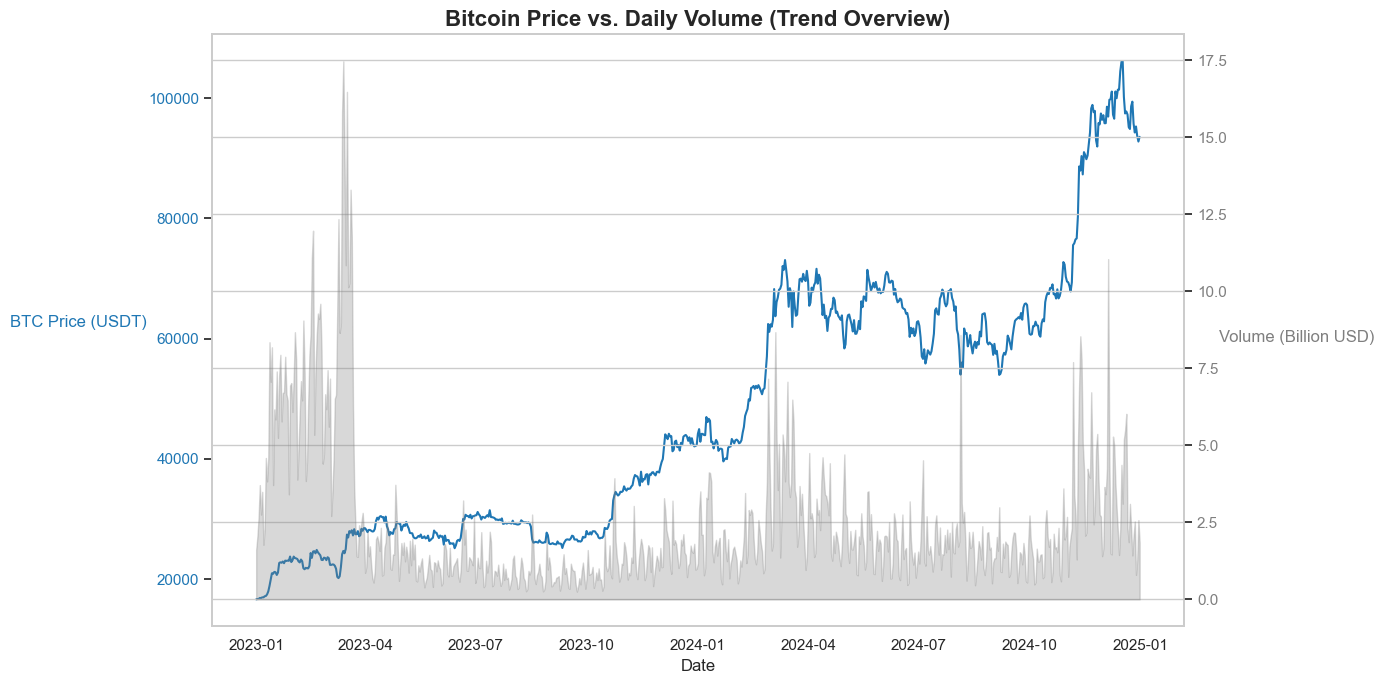

In [161]:
# Resample to Daily average for a clean trend line
df_daily = df.resample('D').agg({
    'close': 'last', 
    'volume_usd': 'sum'
})

# change volume to billions for better readability
df_daily['volume_usd'] = df_daily['volume_usd'] / 1_000_000_000  # in billions

fig, ax1 = plt.subplots(figsize=(14, 7))

# Plot Price on Left Y-axis
color = 'tab:blue'
ax1.set_xlabel('Date')
ax1.set_ylabel('BTC Price (USDT)', color=color, rotation=0, labelpad=50)
ax1.plot(df_daily.index, df_daily['close'], color=color, linewidth=1.5, label='Price')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(False) # Turn off grid for price to keep it clean

# Create a second Y-axis for Volume
ax2 = ax1.twinx()  
color = 'tab:gray'
ax2.set_ylabel('Volume (Billion USD)', color=color, rotation=0, labelpad=50)
ax2.fill_between(df_daily.index, df_daily['volume_usd'], color=color, alpha=0.3, label='Volume')
ax2.tick_params(axis='y', labelcolor=color)

# Title and Layout
plt.title('Bitcoin Price vs. Daily Volume (Trend Overview)', fontsize=16, weight='bold')
fig.tight_layout()
plt.show()

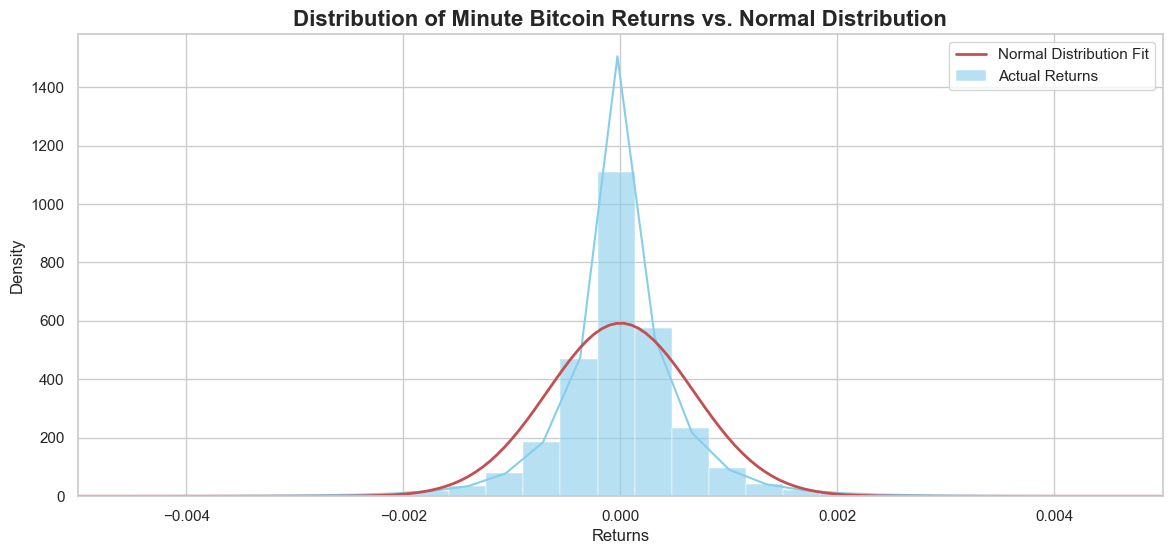

In [162]:


plt.figure(figsize=(14, 6))

# plot the actual data histogram
sns.histplot(df['returns'], bins=200, kde=True, stat="density", color='skyblue', label='Actual Returns', alpha=0.6)

# plot the normal distribution curve    
mu, std = norm.fit(df['returns'])
x = np.linspace(df['returns'].min(), df['returns'].max(), 1000)
p = norm.pdf(x, mu, std)
plt.plot(x, p, 'r', linewidth=2, label='Normal Distribution Fit')

plt.xlim(-0.005, 0.005) # Focus on central part

plt.title('Distribution of Minute Bitcoin Returns vs. Normal Distribution', fontsize=16, weight='bold')
plt.xlabel('Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

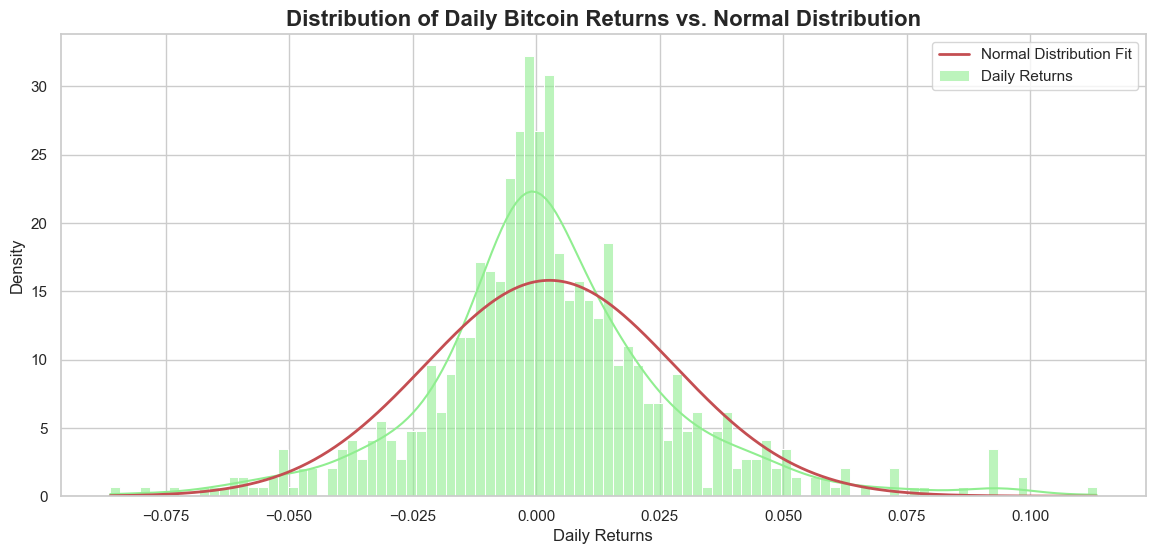

In [163]:
# distribution of daily returns
plt.figure(figsize=(14, 6))
sns.histplot(df.resample('D')['returns'].sum(), bins=100, kde=True, stat="density", color='lightgreen', label='Daily Returns', alpha=0.6)

# plot the normal distribution curve
mu_daily, std_daily = norm.fit(df.resample('D')['returns'].sum())
x_daily = np.linspace(df.resample('D')['returns'].sum().min(), df.resample('D')['returns'].sum().max(), 1000)
p_daily = norm.pdf(x_daily, mu_daily, std_daily)
plt.plot(x_daily, p_daily, 'r', linewidth=2, label='Normal Distribution Fit')


plt.title('Distribution of Daily Bitcoin Returns vs. Normal Distribution', fontsize=16, weight='bold')
plt.xlabel('Daily Returns')
plt.ylabel('Density')
plt.legend()
plt.show()

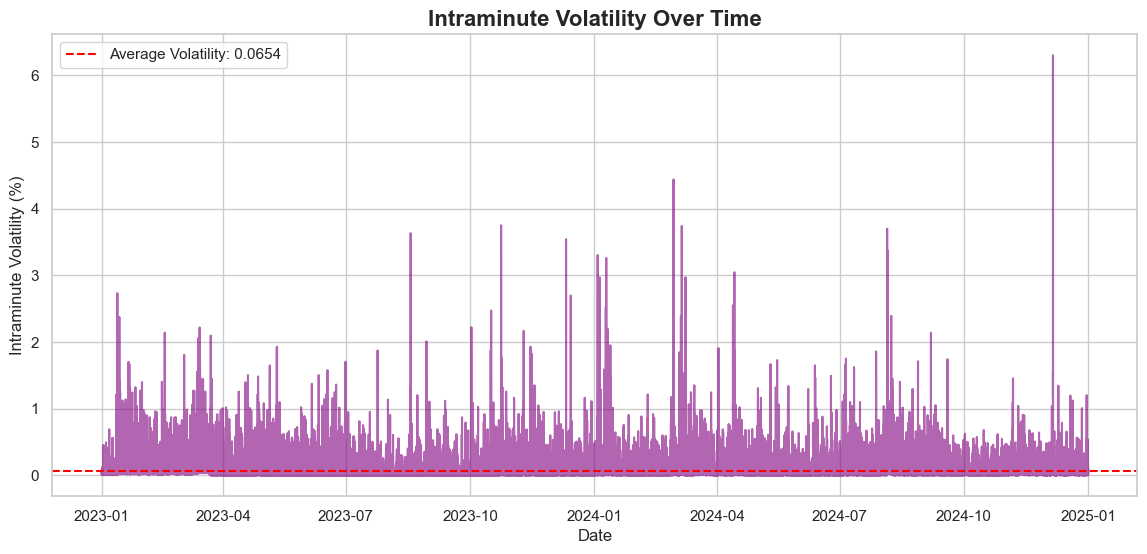

In [164]:
# Volatility Clustering 
plt.figure(figsize=(14, 6))

plt.plot(df.index, df['intra_volatility'], color='purple', alpha=0.6)

plt.title('Intraminute Volatility Over Time', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Intraminute Volatility (%)')

avg_vol = df['intra_volatility'].mean()
plt.axhline(avg_vol, color='red', linestyle='--', label=f'Average Volatility: {avg_vol:.4f}')
plt.legend()

plt.show()

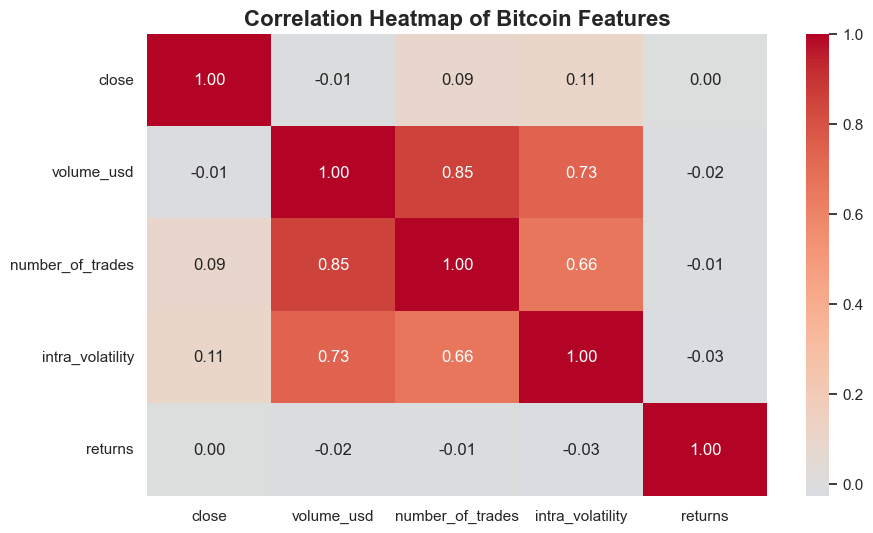

In [165]:
# Heatmap for Multivariate Correlation
corr = df[['close', 'volume_usd', 'number_of_trades', 'intra_volatility', 'returns']].corr()

plt.figure(figsize=(10, 6))

# draw heatmap  
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title('Correlation Heatmap of Bitcoin Features', fontsize=16, weight='bold')
plt.show()

## Feature Engineering for Analysis

In [166]:
df_featured = df.copy()

# drop unneeded columns for modeling: quot_asset_volume, taker_buy_base_asset_volume, taker_buy_quote_asset_volume
df_featured = df_featured.drop(columns=['quote_asset_volume', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'])

### Standard Indicators (RSI, EMA, ATR)

In [167]:
df_featured['ema_50'] = df_featured['close'].ewm(span=50, adjust=False).mean()
df_featured['ema_200'] = df_featured['close'].ewm(span=200, adjust=False).mean()

# RSI - 14 period
delta = df_featured['close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss 
df_featured['rsi_14'] = 100 - (100 / (1 + rs))

# ATR - 14 period 
high_low = df_featured['high'] - df_featured['low']
high_close = np.abs(df_featured['high'] - df_featured['close'].shift())
low_close = np.abs(df_featured['low'] - df_featured['close'].shift())
ranges = pd.concat([high_low, high_close, low_close], axis=1)
true_range = ranges.max(axis=1)
df_featured['atr_14'] = true_range.rolling(window=14).mean()

# Shock Volume
df_featured['vol_ma20'] = df_featured['volume_usd'].rolling(window=20).mean()
df_featured['is_shock_vol'] = np.where(df_featured['volume_usd'] > 2 * df_featured['vol_ma20'], 1, 0)

df_featured.tail()

,open,high,low,close,volume,number_of_trades,returns,log_returns,intra_volatility,volume_usd,ema_50,ema_200,rsi_14,atr_14,vol_ma20,is_shock_vol
open_time,,,,,,,,,,,,,,,,
2024-12-31 23:55:00,93646.970000,93667.520000,93646.960000,93667.520000,4.313390,452,0.000220,0.000220,0.021955,404024.544093,93589.802780,93718.907895,75.301571,33.166429,495484.160387,0
2024-12-31 23:56:00,93667.510000,93676.980000,93636.370000,93636.370000,2.870660,1155,-0.000333,-0.000333,0.043370,268798.181904,93591.628945,93718.086623,72.016267,34.086429,446452.276810,0
2024-12-31 23:57:00,93636.380000,93643.240000,93616.040000,93616.040000,2.192300,698,-0.000217,-0.000217,0.029055,205234.444492,93592.586241,93717.071233,70.470235,33.229286,421787.028305,0
2024-12-31 23:58:00,93616.050000,93616.050000,93600.000000,93600.000000,2.172560,441,-0.000171,-0.000171,0.017147,203351.616000,93592.876977,93715.906345,65.183516,32.513571,396386.079404,0
2024-12-31 23:59:00,93600.010000,93616.050000,93576.000000,93576.000000,5.486620,1062,-0.000256,-0.000256,0.042799,513415.953120,93592.215135,93714.514243,59.724510,34.436429,395157.582639,0


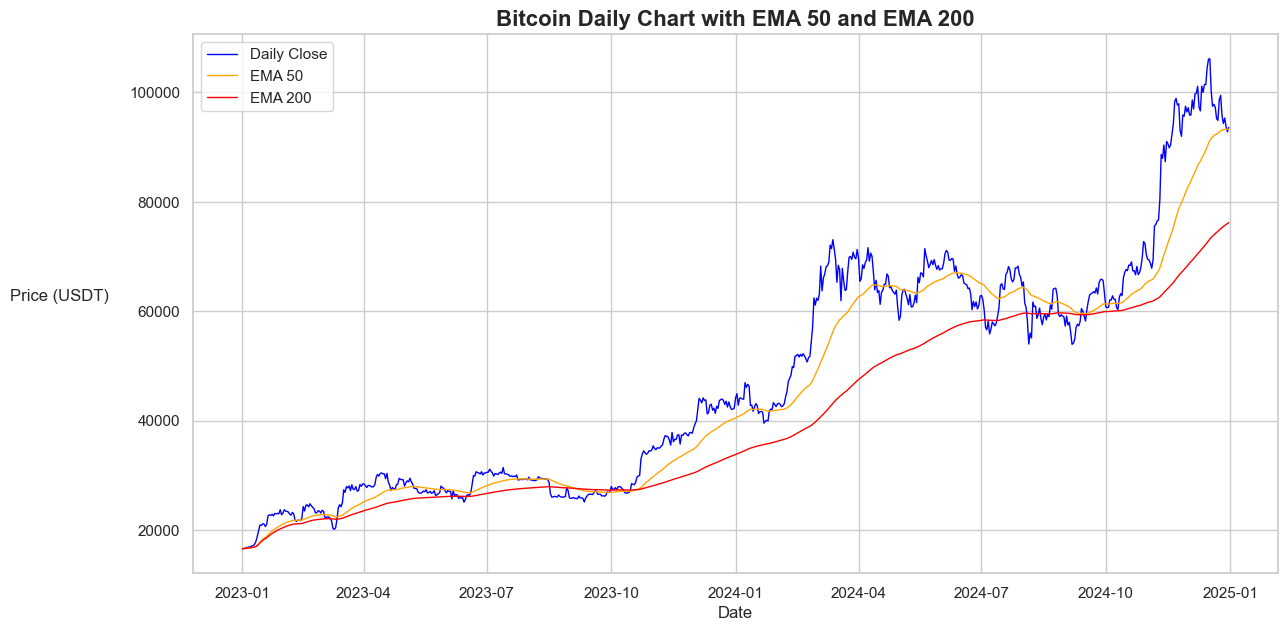

In [168]:
# Chart 1: The Macro Trend (Daily aggregation)
df_daily = df.resample('D').agg({
    'open': 'first', 'high': 'max', 'low': 'min', 'close': 'last', 'volume': 'sum'
})

df_daily['ema_50'] = df_daily['close'].ewm(span=50).mean()
df_daily['ema_200'] = df_daily['close'].ewm(span=200).mean()

# plot the daily chart with EMAs using matplotlib
plt.figure(figsize=(14, 7)) 
plt.plot(df_daily.index, df_daily['close'], label='Daily Close', color='blue', linewidth=1)
plt.plot(df_daily.index, df_daily['ema_50'], label='EMA 50', color='orange', linewidth=1)
plt.plot(df_daily.index, df_daily['ema_200'], label='EMA 200', color='red', linewidth=1)
plt.title('Bitcoin Daily Chart with EMA 50 and EMA 200', fontsize=16, weight='bold')
plt.xlabel('Date')
plt.ylabel('Price (USDT)', rotation=0, labelpad=50)
plt.legend()
plt.show()

### MARKET STRUCTURE (Fractals: HH, LL, LH, HL)

In [169]:
def calculate_market_structure(df, lookback=20, lookforward=10):
    df_struct = df.copy()

    
    # Identify Swing Points 
    is_high_peak = pd.Series(True, index=df_struct.index)
    is_low_valley = pd.Series(True, index=df_struct.index)
    
    # Check left side (Past)
    for i in range(1, lookback + 1):
        is_high_peak &= df_struct['high'] > df_struct['high'].shift(i)
        is_low_valley &= df_struct['low'] < df_struct['low'].shift(i)
        
    # Check right side (Future)
    for i in range(1, lookforward + 1):
        is_high_peak &= df_struct['high'] >= df_struct['high'].shift(-i)
        is_low_valley &= df_struct['low'] <= df_struct['low'].shift(-i)
    
    df_struct['is_swing_high'] = is_high_peak.fillna(False)
    df_struct['is_swing_low'] = is_low_valley.fillna(False)
    
    # Label the Points (HH, HL, LH, LL)
    df_struct['structure_label'] = np.nan
    
    # Get indices of swing points
    high_indices = df_struct.index[df_struct['is_swing_high']]
    low_indices = df_struct.index[df_struct['is_swing_low']]


    # Compare the current swing high to the previous swing high
    prev_high = df_struct['high'].loc[high_indices[0]] # Start with the first one 
    
    for i in high_indices[1:]: # skip the very first one 
        current_high = df_struct['high'].loc[i]
        
        if current_high > prev_high:
            df_struct.at[i, 'structure_label'] = 'HH' # Higher High (Bullish)
        else:
            df_struct.at[i, "structure_label"] = "LH" # Lower High (Bearish)
        
        prev_high = current_high # update previous for the next loop
    
    # Label LOWS (LL and HL)
    # Compare the current swing low to the previous swing low
    prev_low = df_struct['low'].loc[low_indices[0]]
    
    for i in low_indices[1:]:
        current_low = df_struct['low'].loc[i]
        
        if current_low < prev_low:
            df_struct.at[i, "structure_label"] = 'LL' # Lower Low (Bearish)
        else:
            df_struct.at[i, "structure_label"] = "HL" # Higher Low (Bullish)
        
        prev_low = current_low 
    
    return df_struct
    
df_featured = calculate_market_structure(df_featured)
df_featured.tail()
    

,open,high,low,close,volume,number_of_trades,returns,log_returns,intra_volatility,volume_usd,ema_50,ema_200,rsi_14,atr_14,vol_ma20,is_shock_vol,is_swing_high,is_swing_low,structure_label
open_time,,,,,,,,,,,,,,,,,,,
2024-12-31 23:55:00,93646.970000,93667.520000,93646.960000,93667.520000,4.313390,452,0.000220,0.000220,0.021955,404024.544093,93589.802780,93718.907895,75.301571,33.166429,495484.160387,0,False,False,NaN
2024-12-31 23:56:00,93667.510000,93676.980000,93636.370000,93636.370000,2.870660,1155,-0.000333,-0.000333,0.043370,268798.181904,93591.628945,93718.086623,72.016267,34.086429,446452.276810,0,False,False,NaN
2024-12-31 23:57:00,93636.380000,93643.240000,93616.040000,93616.040000,2.192300,698,-0.000217,-0.000217,0.029055,205234.444492,93592.586241,93717.071233,70.470235,33.229286,421787.028305,0,False,False,NaN
2024-12-31 23:58:00,93616.050000,93616.050000,93600.000000,93600.000000,2.172560,441,-0.000171,-0.000171,0.017147,203351.616000,93592.876977,93715.906345,65.183516,32.513571,396386.079404,0,False,False,NaN
2024-12-31 23:59:00,93600.010000,93616.050000,93576.000000,93576.000000,5.486620,1062,-0.000256,-0.000256,0.042799,513415.953120,93592.215135,93714.514243,59.724510,34.436429,395157.582639,0,False,False,NaN


### SMART MONEY CONCEPTS (Order Blocks, Fair Value Gaps)

In [170]:
def calculate_smart_money_features(df):
    df_smc = df.copy()
    
    # ==========================================
    # 1. SETUP: Candle Anatomy
    # ==========================================
    
    # Body size (Absolute value)
    body_size = np.abs(df_smc['close'] - df_smc['open'])
    
    # Total range (High - Low)
    candle_range = df_smc['high'] - df_smc['low']
    
    # Upper and Lower Wicks
    # Upper Wick = High - Max(Open, Close)
    upper_wick = df_smc['high'] - df_smc[['open', 'close']].max(axis=1)
    # Lower Wick = Min(Open, Close) - Low
    lower_wick = df_smc[['open', 'close']].min(axis=1) - df_smc['low']
    
    # Calculate Shock Volume
    # Volume > 2x average of last 20 candles
    avg_vol = df_smc['volume'].rolling(window=20).mean()
    is_shock_vol = df_smc['volume'] > (2 * avg_vol)
    
    # ==========================================
    # 2. ORDER BLOCKS 
    # ==========================================
    
    # Bullish Pinbar, potential demand zone
    df_smc['is_bullish_ob'] = (
        (lower_wick > 2 * body_size) & # Long tail 
        (lower_wick > upper_wick) & # Tail is longer than nose
        (is_shock_vol) # Whales are active
    )
    
    # Bearish Pinbar, potential supply zone
    df_smc['is_bearish_ob'] = (
        (upper_wick > 2 * body_size) & # Long nose
        (upper_wick > lower_wick) &  # Nose is longer than tail
        (is_shock_vol) # Whales are active
    )
    
    # ==========================================
    # 3. FAIR VALUE GAPS (FVG) 
    # ==========================================
    
    
    prev_high = df_smc['high'].shift(2)
    prev_low = df_smc['low'].shift(2)
    
    threshold = df_smc['close'] * 0.0005
    
    
    bullish_gap_size = df_smc['low'] - prev_high
    
    # Bullish FVG: Low > Prev High
    df_smc['is_fvg_bullish'] = (
        (df_smc['low'] > prev_high) & # The Gap exists
        (bullish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] > df_smc['open']) # Current candle is green
    )
    
    bearish_gap_size = prev_low - df_smc['high']
    
    # Bearish FVG: High < Prev Low
    df_smc['is_fvg_bearish'] = (
        (df_smc['high'] < prev_low) & # The Gap exists
        (bearish_gap_size > threshold) & # Gap is large enough
        (df_smc['close'] < df_smc['open']) # Current candle is Red
    )
    
    # Clean up, fill NaNs with False
    
    cols_to_fill = ['is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']
    df_smc[cols_to_fill] = df_smc[cols_to_fill].fillna(False)
    
    return df_smc

df_featured = calculate_smart_money_features(df_featured)

print("Bullish Order Blocks found:", df_featured['is_bullish_ob'].sum())
print("Bullish FVGs found:", df_featured['is_fvg_bullish'].sum())


df_featured[df_featured['is_bullish_ob'] == True][['close', 'is_bullish_ob', 'is_fvg_bullish']].tail()
    

Bullish Order Blocks found: 8417
Bullish FVGs found: 27013


,close,is_bullish_ob,is_fvg_bullish
open_time,,,
2024-12-31 14:37:00,95546.490000,True,False
2024-12-31 16:32:00,94749.830000,True,False
2024-12-31 17:27:00,94646.100000,True,False
2024-12-31 19:06:00,93971.510000,True,False
2024-12-31 21:44:00,93920.500000,True,False


### Summary of Features

In [171]:
# Numerical Stats

def format(x):
    if abs(x) > 1000:
        return f"{x:,.2f}"      # Big numbers: 83,516.71
    elif abs(x) < 0.001:
        return f"{x:.8f}"       # Tiny numbers: 0.00000100
    else:
        return f"{x:.4f}"

numerical_cols = ['intra_volatility', 'rsi_14', 'atr_14']

desc_stats = df_featured[numerical_cols].describe()



desc_stats = desc_stats.applymap(format)
desc_stats = desc_stats.transpose()
# remove count column
desc_stats = desc_stats.drop(columns=['count'])
print("Descriptive Statistics of Featured Data:")
print(desc_stats)

Descriptive Statistics of Featured Data:
                     mean      std         min      25%      50%      75%  \
intra_volatility   0.0654   0.0769  0.00000000   0.0211   0.0462   0.0849   
rsi_14            50.2929  17.3314  0.00000000  38.2049  50.1479  62.3168   
atr_14            32.7480  36.2318  0.00000000  10.2450  21.5814  42.2307   

                       max  
intra_volatility    6.2983  
rsi_14            100.0000  
atr_14            1,346.88  


In [172]:
# Boolean/Signal Frequency
bool_cols = ['is_shock_vol', 'is_bullish_ob', 'is_bearish_ob', 'is_fvg_bullish', 'is_fvg_bearish']
bool_cols_rename = {
    'is_shock_vol': 'Shock Volume',
    'is_bullish_ob': 'Bullish Order Block',
    'is_bearish_ob': 'Bearish Order Block',
    'is_fvg_bullish': 'Bullish FVG',
    'is_fvg_bearish': 'Bearish FVG'
}

bool_summary = {col: df_featured[col].sum() for col in bool_cols}
total = len(df_featured)
print("\nBoolean Feature Counts:")
for col, count in bool_summary.items():
    print(f"{bool_cols_rename[col]}: {count} ({(count/total)*100:.2f}%)")


Boolean Feature Counts:
Shock Volume: 88981 (8.45%)
Bullish Order Block: 8417 (0.80%)
Bearish Order Block: 7420 (0.70%)
Bullish FVG: 27013 (2.57%)
Bearish FVG: 25294 (2.40%)


In [173]:
# remove rows with nah values in "rsi_14" and "atr_14"
df_featured = df_featured.dropna(subset=['rsi_14', 'atr_14'])
# Save to csv file
df_featured.to_csv("Data/bitcoin_data_feature_engineered.csv", index=True)

## Data Clustering

In [175]:
df_featured = pd.read_csv("Data/bitcoin_data_feature_engineered.csv", parse_dates=['open_time'])
df_featured.set_index('open_time', inplace=True)
df_featured.head()

,open,high,low,close,volume,number_of_trades,returns,log_returns,intra_volatility,volume_usd,...,atr_14,vol_ma20,is_shock_vol,is_swing_high,is_swing_low,structure_label,is_bullish_ob,is_bearish_ob,is_fvg_bullish,is_fvg_bearish
open_time,,,,,,,,,,,,,,,,,,,,,
2023-01-01 00:14:00,16524.600000,16525.530000,16520.000000,16520.690000,58.343190,2356,-0.000211,-0.000211,0.033475,963869.755601,...,5.997857,NaN,0,False,False,NaN,False,False,False,False
2023-01-01 00:15:00,16521.260000,16526.840000,16519.400000,16521.000000,114.312890,3643,0.000019,0.000019,0.045038,1888563.255690,...,6.105714,NaN,0,False,False,NaN,False,False,False,False
2023-01-01 00:16:00,16521.560000,16523.960000,16517.720000,16519.620000,140.093790,3534,-0.000084,-0.000084,0.037778,2314296.175160,...,6.076429,NaN,0,False,False,NaN,False,False,False,False
2023-01-01 00:17:00,16519.140000,16522.900000,16517.720000,16522.480000,47.003520,1824,0.000173,0.000173,0.031360,776614.719130,...,5.997857,NaN,0,False,False,NaN,False,False,False,False
2023-01-01 00:18:00,16522.180000,16530.990000,16521.440000,16530.340000,94.057250,2693,0.000476,0.000476,0.057804,1554798.321965,...,6.067857,NaN,0,False,False,NaN,False,False,False,False


### Preprocessing for Clustering

In [176]:
def create_wyckoff_features(df):
    df_w = df.copy()
    
    df_w['trend_maturity'] = (df_w['ema_50'] - df_w['ema_200']) / df_w['close'] * 100
    
    df_w['trend_tactical'] = (df_w['close'] - df_w['ema_50']) / df_w['ema_50'] * 100
    
    # efficiency 
    # high efficiency = markup / markdown  
    # low efficiency = accumulation / distribution 
    epsilon = 1e-9
    range_len = df_w['high'] - df_w['low'] 
    body_len = abs(df_w['close'] - df_w['open'])
    
    raw_efficiency = body_len / (range_len + epsilon)
    df_w['efficiency_regime'] = raw_efficiency.rolling(window=20).mean()
    
    # Volume   
    df_w['rel_volume'] = df_w['volume_usd'] / df_w['vol_ma20']
    df_w['vol_regime'] = df_w['rel_volume'].rolling(window=1).mean()
    
    # Structure 
    structure_score = np.zeros(len(df_w))
    current_score = 0 
    decay = 0.98
    
    bull_ob = df_w['is_bullish_ob'].fillna(0).values
    bear_ob = df_w['is_bearish_ob'].fillna(0).values
    fvg_bull = df_w['is_fvg_bullish'].fillna(0).values
    fvg_bear = df_w['is_fvg_bearish'].fillna(0).values
    
    for i in range(1, len(df_w)):
        current_score *= decay
        
        # OBs are structural pivots
        if bull_ob[i] == 1: current_score += 1.0
        if bear_ob[i] == 1: current_score -= 1.0 
        
        # Momentum from FVGs
        if fvg_bull[i] == 1: current_score += 0.5
        if fvg_bear[i] == 1: current_score -= 0.5
        
        structure_score[i] = current_score
    df_w['structure_score'] = structure_score
    
    final_features = [
        "trend_tactical", # short term location
        "trend_maturity", # long term location
        "efficiency_regime", # candle characteristic
        "vol_regime",      # effort
        "structure_score"  # market structure
    ]
    
    return df_w[final_features].dropna()

df_clustering = create_wyckoff_features(df_featured)
df_clustering.head()

    

,trend_tactical,trend_maturity,efficiency_regime,vol_regime,structure_score
open_time,,,,,
2023-01-01 00:33:00,-0.019776,-0.012461,0.504495,0.824564,0.000000
2023-01-01 00:34:00,-0.045090,-0.013714,0.489683,1.480899,0.000000
2023-01-01 00:35:00,-0.064764,-0.015555,0.506175,1.526922,0.000000
2023-01-01 00:36:00,-0.082216,-0.017909,0.506690,1.899460,0.000000
2023-01-01 00:37:00,-0.110201,-0.021097,0.494159,2.045838,0.000000


### Clustering and Interpretation

In [177]:
from sklearn.preprocessing import StandardScaler 
from sklearn.cluster import KMeans


# Scale the features
scaler = StandardScaler()
X = scaler.fit_transform(df_clustering)

# Cluster using KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X)

df_clustering['cluster'] = clusters

summary = df_clustering.groupby('cluster').mean()

# add count to see distribution
summary['count'] = df_clustering['cluster'].value_counts()


print("Cluster Summary:")
print(summary)



Cluster Summary:
         trend_tactical  trend_maturity  efficiency_regime  vol_regime  \
cluster                                                                  
0              0.195195        0.284700           0.567046    0.920679   
1              0.002378        0.008815           0.750799    0.833197   
2             -0.011432        0.004950           0.699194    3.568556   
3             -0.131947       -0.188056           0.529865    0.896539   

         structure_score   count  
cluster                           
0               0.781771  213019  
1               0.016469  493383  
2               0.049858   59253  
3              -0.295516  286802  


### Evaluation of Clustering

In [178]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

labels = kmeans.labels_
labels

# Metric 1: Inertia
print(f"Inertia: {kmeans.inertia_:.4f}") 
print(f"Average Inertia per sample: {kmeans.inertia_ / len(X):.6f}")

# Metric 2: Silhouette Score
sample_size = 50000
if len(X) > sample_size:
    indices = np.random.choice(len(X), sample_size, replace=False)
    X_sample = X[indices]
    labels_sample = labels[indices]
else:
    X_sample = X
    labels_sample = labels
    
sil_score = silhouette_score(X_sample, labels_sample)
print(f"Silhouette Score: {sil_score:.4f}")

# Metric 3: Davies-Bouldin Index
db_score = davies_bouldin_score(X, labels)
print(f"Davies-Bouldin Index: {db_score:.4f}")

# Metric 4: Calinski-Harabasz Index
ch_score = calinski_harabasz_score(X, labels)
print(f"Calinski-Harabasz Index: {ch_score:.4f}")

Inertia: 3336295.1504
Average Inertia per sample: 3.170006
Silhouette Score: 0.2191
Davies-Bouldin Index: 1.4146
Calinski-Harabasz Index: 202523.2818


In [ ]:
df_clustering['cluster'].value_counts()
# Distribution of clusters of the train set

cluster
2    432128
1    282328
3    239737
0     56643
Name: count, dtype: int64

### visualization of Clusters

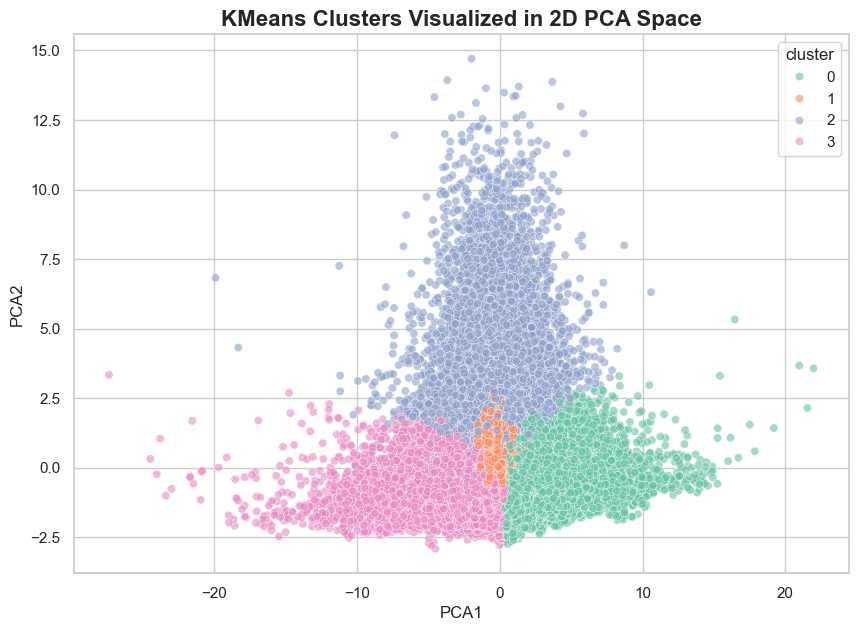

In [179]:
# Visualize Clusters in 2D using PCA
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
df_pca = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
df_pca['cluster'] = df_clustering['cluster'].values
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PCA1', y='PCA2', hue='cluster', palette='Set2', alpha=0.6)
plt.title('KMeans Clusters Visualized in 2D PCA Space', fontsize=16, weight='bold')
plt.show()

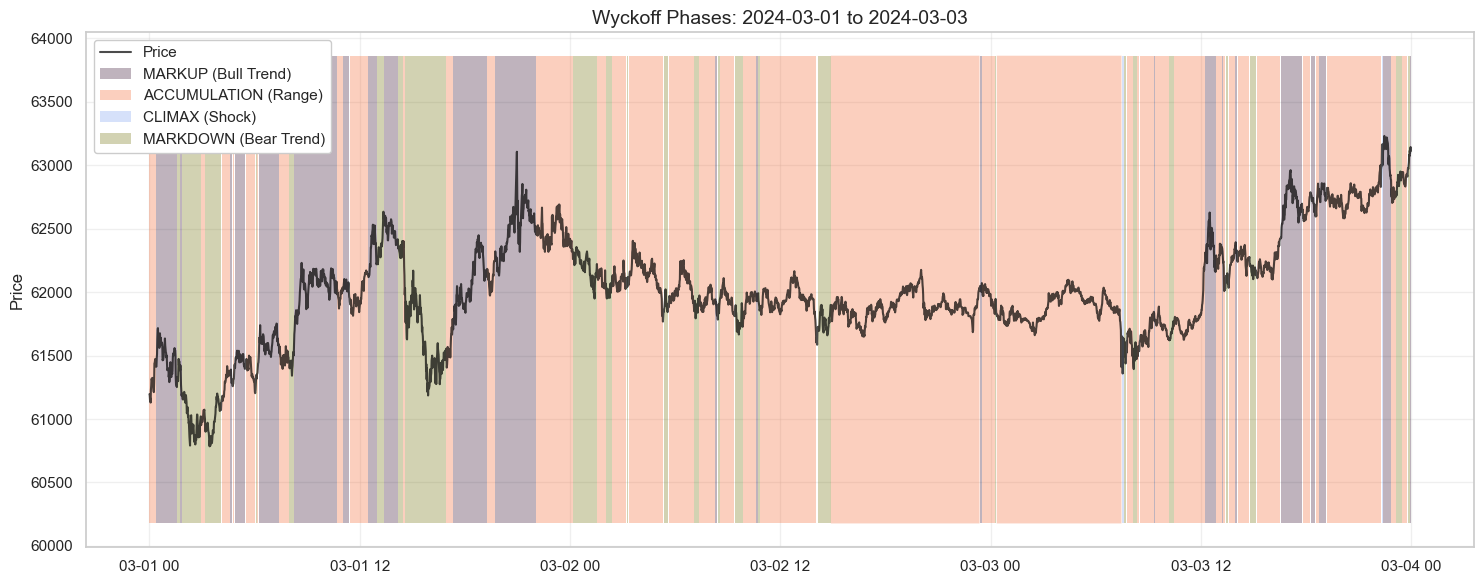

In [186]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_wyckoff_zoom(df_clusters, df_prices, start_date, end_date, smooth_window=10):
    """
    Plots Price vs Wyckoff Clusters for a specific time interval.
    """
    # 1. Prepare Data Slice
    subset = df_clusters.loc[start_date:end_date].copy()
    subset['close'] = df_prices.loc[start_date:end_date, 'close']
    
    # 2. Apply Smoothing 
    subset['smooth_cluster'] = subset['cluster'].rolling(window=smooth_window).apply(
        lambda x: pd.Series(x).mode()[0] if not pd.Series(x).mode().empty else x[int(smooth_window/2)], 
        raw=True
    ).fillna(method='bfill')

    # 3. Define Colors 
    colors = {0: "#2b0527", 1: "#f5632a", 2: "#789cf0", 3: "#6d6b03"}
    labels = {0: 'MARKUP (Bull Trend)', 1: 'ACCUMULATION (Range)', 2: 'CLIMAX (Shock)', 3: 'MARKDOWN (Bear Trend)'}

    # 4. Plot
    fig, ax = plt.subplots(figsize=(15, 6))
    
    # Plot Price Line
    ax.plot(subset.index, subset['close'], color='black', linewidth=1.5, alpha=0.7, label='Price')

    # Paint Background (Vectorized)
    for cluster_id, color in colors.items():
        mask = (subset['smooth_cluster'] == cluster_id)
        ax.fill_between(
            subset.index, 
            y1=subset['close'].min() * 0.99, # Dynamic Y-limits for the zoom
            y2=subset['close'].max() * 1.01, 
            where=mask, 
            color=color, alpha=0.3, 
            linewidth=0, step='mid',
            label=labels[cluster_id]
        )

    # Styling
    ax.set_title(f"Wyckoff Phases: {start_date} to {end_date}", fontsize=14)
    ax.set_ylabel("Price")
    ax.legend(loc='upper left', frameon=True, fancybox=True, framealpha=1)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()



plot_wyckoff_zoom(df_clustering, df_featured, '2024-03-01', '2024-03-03', smooth_window=10)

## Association Pattern Mining

In [187]:
df_association = df_clustering.copy()

# get close, high, low, atr_14 from df_featured
df_association[['close', 'high', 'low', 'atr_14', 'rsi_14']] = df_featured[['close', 'high', 'low', 'atr_14', 'rsi_14']]
df_association.head()

,trend_tactical,trend_maturity,efficiency_regime,vol_regime,structure_score,cluster,close,high,low,atr_14,rsi_14
open_time,,,,,,,,,,,
2023-01-01 00:33:00,-0.019776,-0.012461,0.504495,0.824564,0.000000,3,16532.320000,16534.060000,16530.300000,5.207857,46.840328
2023-01-01 00:34:00,-0.045090,-0.013714,0.489683,1.480899,0.000000,3,16527.830000,16532.960000,16522.030000,5.726429,40.085818
2023-01-01 00:35:00,-0.064764,-0.015555,0.506175,1.526922,0.000000,3,16524.140000,16530.090000,16521.510000,6.082857,33.037891
2023-01-01 00:36:00,-0.082216,-0.017909,0.506690,1.899460,0.000000,3,16520.700000,16526.830000,16516.120000,6.262857,34.593968
2023-01-01 00:37:00,-0.110201,-0.021097,0.494159,2.045838,0.000000,3,16515.330000,16520.720000,16508.390000,6.655714,22.206769


### Data Preparation

In [230]:
def prepare_target(df, horizon=45, atr_multiplier=3.0):
    data = df.copy()
    
    indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=horizon)
    data['future_high'] = data['high'].rolling(window=indexer).max()
    data['future_low'] = data['low'].rolling(window=indexer).min()
    
    bull_barrier = data['close'] + (data['atr_14'] * atr_multiplier)
    bear_barrier = data['close'] - (data['atr_14'] * atr_multiplier)
    
    hit_profit = data['future_high'] >= bull_barrier
    hit_stop   = data['future_low'] <= bear_barrier
    
    conditions = [
        (hit_profit & hit_stop), # Hit Both (Whipsaw)
        hit_stop,                # Hit Stop Only
        hit_profit               # Hit Profit Only
    ]
    
    # CHANGE: Map Whipsaws to 'Sideways' to clean the signals
    choices = [
        'Sideways',  # Was 'Dump' -> Now 'Sideways' (Ignore noise)
        'Dump', 
        'Pump'
    ]
    
    data['target_label'] = np.select(conditions, choices, default='Sideways')
    data.loc[data['atr_14'] <= 0, 'target_label'] = 'Sideways'
    return data.dropna(subset=['target_label'])

# Try these balanced settings:
df_association = prepare_target(df_association, horizon=60, atr_multiplier=3.0)
df_association['target_label'].value_counts()

target_label
Sideways    371690
Dump        342794
Pump        337973
Name: count, dtype: int64

In [231]:
df_association.head()

,trend_tactical,trend_maturity,efficiency_regime,vol_regime,structure_score,cluster,close,high,low,atr_14,rsi_14,future_high,future_low,target_label
open_time,,,,,,,,,,,,,,
2023-01-01 00:33:00,-0.019776,-0.012461,0.504495,0.824564,0.000000,3,16532.320000,16534.060000,16530.300000,5.207857,46.840328,16541.800000,16508.390000,Dump
2023-01-01 00:34:00,-0.045090,-0.013714,0.489683,1.480899,0.000000,3,16527.830000,16532.960000,16522.030000,5.726429,40.085818,16541.800000,16508.390000,Dump
2023-01-01 00:35:00,-0.064764,-0.015555,0.506175,1.526922,0.000000,3,16524.140000,16530.090000,16521.510000,6.082857,33.037891,16541.800000,16508.390000,Sideways
2023-01-01 00:36:00,-0.082216,-0.017909,0.506690,1.899460,0.000000,3,16520.700000,16526.830000,16516.120000,6.262857,34.593968,16541.800000,16508.390000,Pump
2023-01-01 00:37:00,-0.110201,-0.021097,0.494159,2.045838,0.000000,3,16515.330000,16520.720000,16508.390000,6.655714,22.206769,16541.800000,16508.390000,Pump


In [232]:
def discretize_features(df):
    data = df.copy()
    
    # RSI
    data['RSI_Bin'] = pd.cut(data['rsi_14'],
                             bins=[-np.inf, 30, 45, 55, 70, np.inf],
                             labels=['RSI_Oversold', 'RSI_Bearish', 'RSI_Neutral', 'RSI_Bullish', 'RSI_Overbought'])
    
    # Volume Regime 
    data['Vol_Bin'] = pd.cut(data['vol_regime'],
                             bins=[-np.inf, 0.5, 1.5, 3.0, np.inf],
                             labels=['Vol_Low', 'Vol_Normal', 'Vol_High', 'Vol_Shock'])

    # Trend Tactical
    data['Trend_Bin'] = pd.cut(data['trend_tactical'],
                              bins=[-np.inf, -0.6, -0.1, 0.1, 0.6, np.inf],
                              labels=['Trend_Overextended_Bear', 'Trend_Bearish', 'Trend_Neutral', 'Trend_Bullish', 'Trend_Overextended_Bull'])
    
    # Structure Score
    data['Struct_Bin'] = pd.cut(data['structure_score'],
                                bins=[-np.inf, -0.5, 0.5, np.inf],
                                labels=['Struct_Bear', 'Struct_Neutral', 'Struct_Bull'])
    
    # Wyckoff Cluster
    cluster_map = {
        0: 'Phase_Markup',
        1: 'Phase_Accumulation',
        2: 'Phase_Climax',
        3: 'Phase_Markdown'
    }
    
    data['Phase_Label'] = data['cluster'].map(cluster_map)
    
    # Clean up
    cols_to_keep = ['Phase_Label', 'RSI_Bin', 'Vol_Bin', 'Trend_Bin', 'Struct_Bin', 'target_label']
    
    return data[cols_to_keep].dropna().astype(str)

transactions = discretize_features(df_association)
transactions.head()

,Phase_Label,RSI_Bin,Vol_Bin,Trend_Bin,Struct_Bin,target_label
open_time,,,,,,
2023-01-01 00:33:00,Phase_Markdown,RSI_Neutral,Vol_Normal,Trend_Neutral,Struct_Neutral,Dump
2023-01-01 00:34:00,Phase_Markdown,RSI_Bearish,Vol_Normal,Trend_Neutral,Struct_Neutral,Dump
2023-01-01 00:35:00,Phase_Markdown,RSI_Bearish,Vol_High,Trend_Neutral,Struct_Neutral,Sideways
2023-01-01 00:36:00,Phase_Markdown,RSI_Bearish,Vol_High,Trend_Neutral,Struct_Neutral,Pump
2023-01-01 00:37:00,Phase_Markdown,RSI_Oversold,Vol_High,Trend_Bearish,Struct_Neutral,Pump


### Visualization of Frequent Patterns

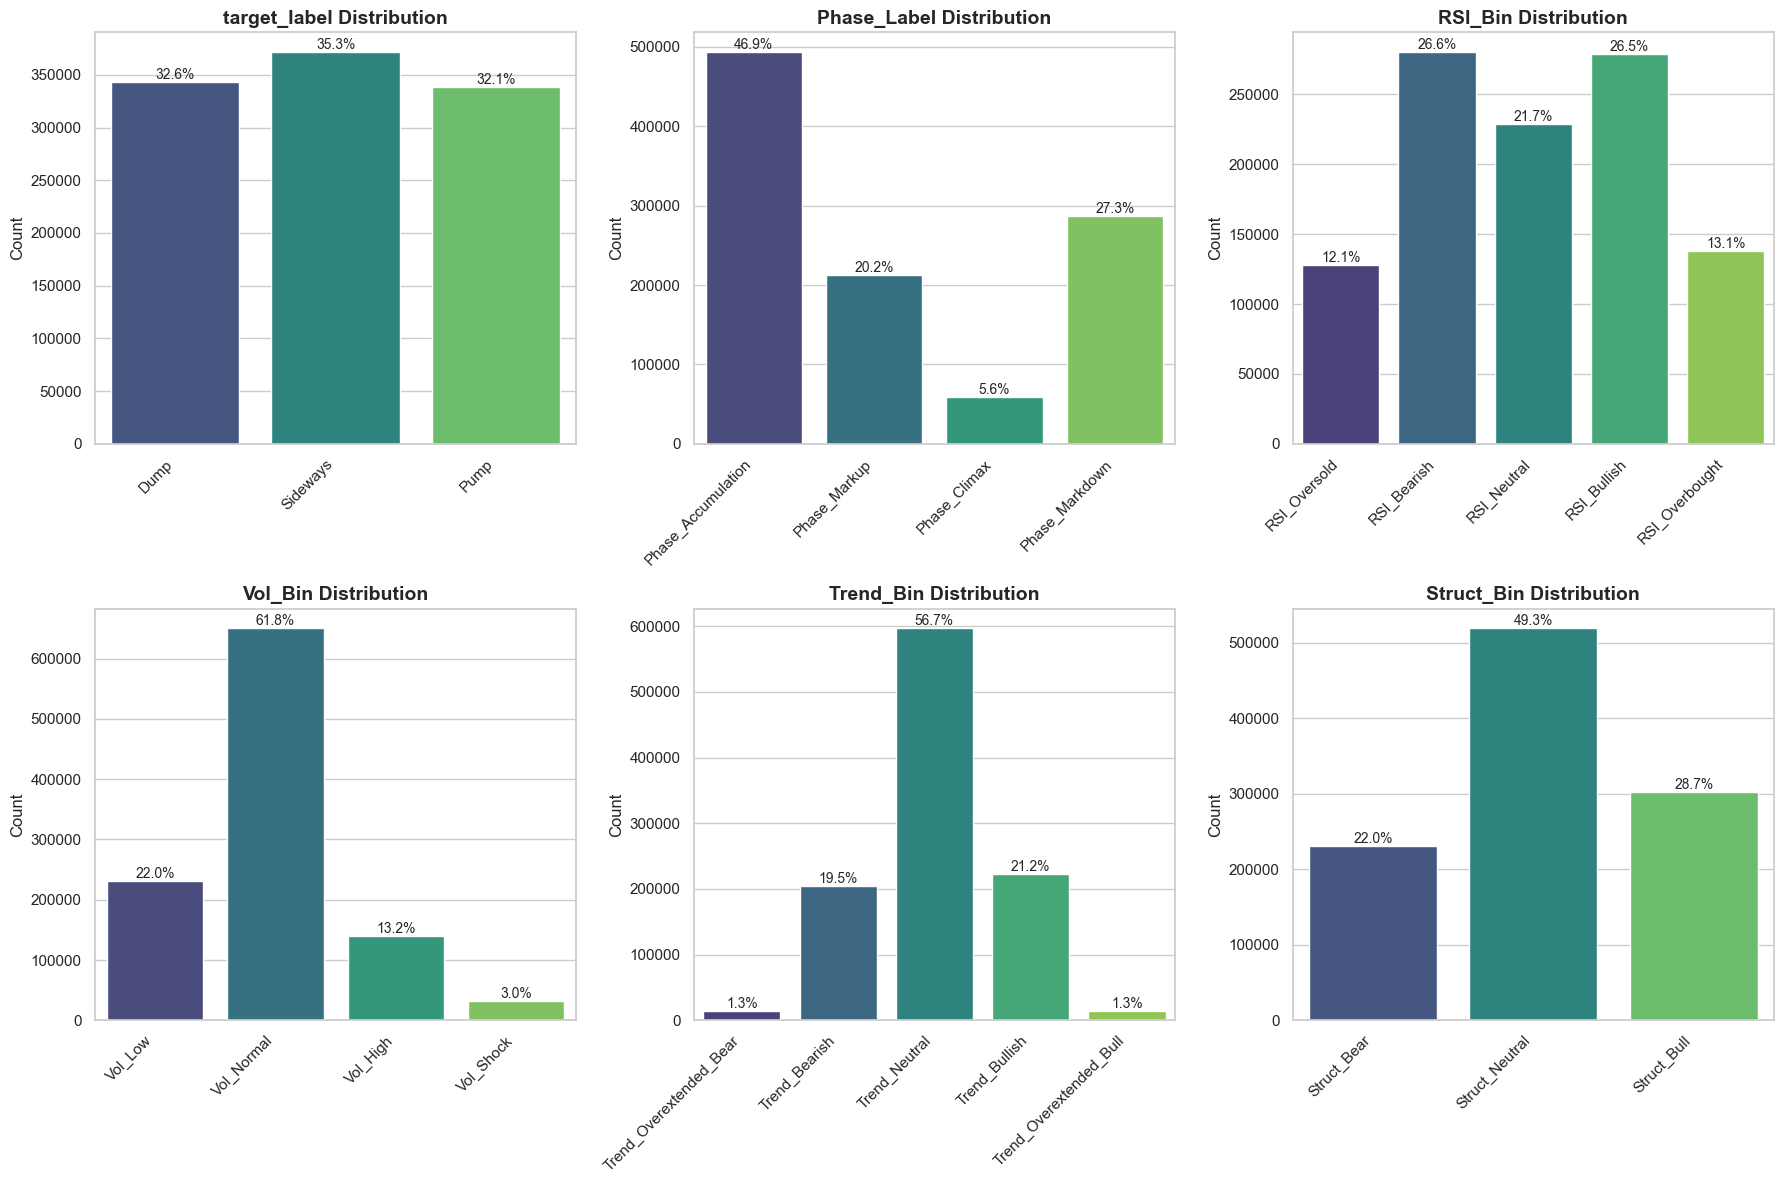

In [233]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1. Define Logical Orders 
orders = {
    'target_label': ['Dump', 'Sideways', 'Pump'],
    'Phase_Label':  ['Phase_Accumulation', 'Phase_Markup', 'Phase_Climax', 'Phase_Markdown'], # Cycle Order
    'RSI_Bin':      ['RSI_Oversold', 'RSI_Bearish', 'RSI_Neutral', 'RSI_Bullish', 'RSI_Overbought'],
    'Vol_Bin':      ['Vol_Low', 'Vol_Normal', 'Vol_High', 'Vol_Shock'],
    'Trend_Bin':    ['Trend_Overextended_Bear', 'Trend_Bearish', 'Trend_Neutral', 'Trend_Bullish', 'Trend_Overextended_Bull'],
    'Struct_Bin':   ['Struct_Bear', 'Struct_Neutral', 'Struct_Bull']
}

# 2. Plotting Function with Percentages
def plot_distributions(df):
    plt.figure(figsize=(18, 12))
    columns = ['target_label', 'Phase_Label', 'RSI_Bin', 'Vol_Bin', 'Trend_Bin', 'Struct_Bin']
    
    for i, col in enumerate(columns, 1):
        plt.subplot(2, 3, i)
        
        # Calculate percentages
        total = len(df)
        ax = sns.countplot(data=df, x=col, order=orders[col], palette='viridis')
        
        plt.title(f'{col} Distribution', fontsize=14, fontweight='bold')
        plt.xlabel('')
        plt.ylabel('Count')
        plt.xticks(rotation=45, ha='right') # Rotate labels to fit
        
        # Add Percentage Text on Bars
        for p in ax.patches:
            percentage = '{:.1f}%'.format(100 * p.get_height() / total)
            x = p.get_x() + p.get_width() / 2
            y = p.get_height()
            ax.annotate(percentage, (x, y), ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.show()

# Run it
plot_distributions(transactions)

In [234]:
transactions.to_csv("Data/bitcoin_transactions.csv", index=True)

## Pattern Mining

In [235]:
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth, association_rules

# Prepare transactions 
# check if transactions is a DataFrame
if isinstance(transactions, pd.DataFrame):
    transactions = transactions.values.tolist()

# encode data
te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df_encoded = pd.DataFrame(te_ary, columns=te.columns_)

# run FP-Growth
print("Running FP-Growth Algorithm...")
frequent_itemsets = fpgrowth(df_encoded, min_support=0.001, use_colnames=True)
print(f"Found {len(frequent_itemsets)} frequent itemsets.")

# Generate Association Rules
print("Generating Association Rules...")
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.1)

# Convert frozensets to strings for better readability
rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

# Find buy zones 
buy_zones = rules[
    (rules['consequents'] == 'Pump') & 
    (rules['lift'] > 1.1) & 
    (rules['confidence'] > 0.35)
].sort_values(by='confidence', ascending=False)

# Find sell zones
sell_zones = rules[
    (rules['consequents'] == 'Dump') & 
    (rules['lift'] > 1.1) & 
    (rules['confidence'] > 0.4)
].sort_values(by='confidence', ascending=False)

# Display Results
print("\n" + "="*40)
print("Top 10 Buy Zone Rules (Pump):")
print(buy_zones[['antecedents', 'support', 'confidence', 'lift']].head(10))
print("\n" + "="*40)
print("Top 10 Sell Zone Rules (Dump):")
print(sell_zones[['antecedents', 'support', 'confidence', 'lift']].head(10))



Running FP-Growth Algorithm...


KeyboardInterrupt: 

In [ ]:
# Save rules to CSV
rules.to_csv("Data/association_rules_bitcoin.csv", index=False)

In [ ]:
# Save kmeans model
import joblib
import os 
# Make sure directory exists
os.makedirs("Models", exist_ok=True)
joblib.dump(kmeans, "Models/kmeans_wyckoff_model.pkl")

['Models/kmeans_wyckoff_model.pkl']